<a href="https://colab.research.google.com/github/charlesreid1/deep-learning-genomics/blob/master/keras_sklearn_cnn1d_dna_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras and Sklearn for Deep Learning Genomics

This notebook continues with the example from a prior notebook, namely, the problem of predicting transcription factor binding sites in DNA. This type of neural network operates on 1D sequence data (DNA nucleotides), so we build a 1D convolutional neural network to perform classification of DNA (is this string of nucleotides a transcription factor binding site or not).

## Import Libraries

In [132]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
import math
import numpy as np
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import joblib

In [0]:
# sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Model
from keras.layers import Flatten, Embedding, Dense, Dropout, Input, Concatenate
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import LeakyReLU
import keras

In [0]:
seed = 1729
numpy.random.seed(seed)

## Define Useful Keras Metrics

In [0]:
# via https://github.com/keras-team/keras/issues/6507#issuecomment-322857357

import keras.backend as K

def precision(y_true, y_pred):
    # Calculate the precision
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculate the recall
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fvalue(y_true, y_pred):
    # Calculate the F-value
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true,y_pred)
    r = recall(y_true,y_pred)
    fvalue = (2 * p * r)/(p + r + K.epsilon())
    return fvalue


## Load Dataset

In [138]:
!git clone https://github.com/deepchem/DeepLearningLifeSciences.git

fatal: destination path 'DeepLearningLifeSciences' already exists and is not an empty directory.


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/{test*,train*,valid*} .

In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/chromatin.txt

In contrast to the prior example, which uses the already-provided splits of training, testing, and validation, we will load all of the data all at once into a single X and y pair and use sklearn to split the data into testing and training sets.

In [141]:
def load_all_data():
    
    # load chromatin accessibility data
    accessibility = {}
    for line in open('chromatin.txt','r'):
        fields = line.split()
        accessibility[fields[0]] = float(fields[1])
    
    # load training, validation, and testing sets
    for i,label in enumerate(['train','valid','test']):
        datadir = "%s_dataset"%(label)
        base_filename = "shard-0-%s.joblib"
        X_filename = os.path.join(datadir,base_filename%("X"))
        y_filename = os.path.join(datadir,base_filename%("y"))
        w_filename = os.path.join(datadir,base_filename%("w"))
        ids_filename = os.path.join(datadir,base_filename%("ids"))
        
        this_X = joblib.load(X_filename)
        this_y = joblib.load(y_filename)
        this_w = joblib.load(w_filename)
        this_ids = joblib.load(ids_filename)
        this_chromatin = np.array([accessibility[k] for k in this_ids])
        
        # add X and chromatin data
        if i>0:
            X = np.concatenate([X,this_X])
            chromatin = np.concatenate([chromatin,this_chromatin])
            y = np.concatenate([y,this_y])
            w = np.concatenate([w,this_w])
            ids = np.concatenate([ids,this_ids])
        else:
            X = this_X
            chromatin = this_chromatin
            y = this_y
            w = this_w
            ids = this_ids
        
    return [X,chromatin], y, w, ids

[X,chromatin], y, w, ids = load_all_data()

print("Shape of all data:\n")

print("X shape:")
print(np.shape(X))

print("chromatin shape:")
print(np.shape(chromatin))

print("y shape:")
print(np.shape(y))

print("w shape:")
print(np.shape(w))

Shape of all data:

X shape:
(345271, 101, 4)
chromatin shape:
(345271,)
y shape:
(345271, 1)
w shape:
(345271, 1)


## Stratified K-Fold Validation

Now that we've loaded every data point into a single giant input list, we use scikit-learn to cut the data into training, testing, and validation parts.

We use the "normal" kernel initializer, which initializes perceptron weights using normally-distributed random numbers.

In [0]:
def create_baseline():
    """Create and return a baseline 1D convolutional neural net model.
    This model does not incorporate chromatin accessibility data.
    """
    # DNA sequence alphabet size
    n_features = 4
    seq_length = 101
    convolution_window = 10
    n_filters = 16
    
    # construct model
    model = Sequential()
    
    # Layer 1
    model.add(Conv1D(n_filters, convolution_window,
                     activation='relu',
                     padding='same',
                     kernel_initializer='normal',
                     input_shape=(seq_length, n_features)))
    
    model.add(Dropout(0.5))
    
    # Layer 2
    model.add(Conv1D(n_filters, convolution_window,
                     activation='relu', 
                     padding='same',
                     kernel_initializer='normal'))
    
    model.add(Dropout(0.5))
    
    # Layer 3
    model.add(Conv1D(n_filters, convolution_window,
                     activation='relu', 
                     padding='same',
                     kernel_initializer='normal'))
    
    model.add(Dropout(0.5))
    
    # Flatten
    model.add(Flatten())
    
    # Shrink to 1 neuron for 1 class (binary) classification
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  sample_weight_mode=None,
                  metrics=['accuracy',
                           precision,
                           recall,
                           fvalue])
    
    return model

In [0]:
def create_chromatin():
    """Create and return a 1D convolutional neural net model.
    This model incorporates chromatin accessibility data.
    """
    # DNA sequence alphabet size
    n_features = 4
    seq_length = 101
    convolution_window = 10
    n_filters = 16
    
    # ----------------------------
    # Sequence branch of network
    # (1D DNA sequence)
    
    # Input
    seq_in = Input(shape=(seq_length,n_features))
    
    # Fencepost pattern
    seq = seq_in
    
    # Convolutional layers
    for i in range(3):
        seq = Conv1D(n_filters, convolution_window,
                    activation='relu', padding='same')(seq)
        seq = Dropout(0.5)(seq)
    
    # Flatten to 1D
    seq = Flatten()(seq)
    
    # Assemble the sequential branch of network
    seq = keras.Model(inputs=seq_in, outputs=seq)
    
    # ---------------------------
    # Chromatin branch of network
    
    # Input
    chrom_input = Input(shape=(1,))
    
    # ---------------------------
    # Combine networks
    fin = keras.layers.concatenate([seq.output, chrom_input])
    fin = Dense(1,activation='sigmoid')(fin)
    chrom_model = keras.Model(inputs=[seq.input,chrom_input], outputs=fin)
    
    # Compile model
    chrom_model.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       sample_weight_mode=None,
                       metrics=['accuracy',
                               precision,
                               recall,
                               fvalue])
    
    return chrom_model

## Performing Cross Validation Automatically with sklearn

If we perform n-fold cross validation, we will create n different models with n different splits (for example 10-fold cross validation will create a new model from scratch and re-train it on all the data 10 times). So, turn off verbosity unless you want lots of output.

We have already created our Keras model (above) in a function. To perform cross-validation automatically with sklearn, we need to create two things:

* A [KerasClassifier](https://keras.io/scikit-learn-api/) object - this class is provided by the Keras library to wrap a Keras model in a way that scikit-learn knows how to use. This allows us to create a generic Keras model in a function (above) and have sklearn know how to call it to assemble new Keras models.

* A [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) object to fold (or split) the data in k different ways, in a way that is stratified (meaning, the proportions of classes remains the same across folds). By randomizing how the items are split into training and testing sets, we can create k different versions of training and testing sets from the same data, train k different models, and collect statistics to find which model is best. 

* A [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) object (similar to above, but gives more control over the amount of data in the training versus testing data sets).

In [0]:
n_epochs = 20
n_fold = 2

estimator = KerasClassifier(build_fn=create_baseline, 
                            epochs=n_epochs, 
                            batch_size = 1000,
                            verbose=1)

kfold = StratifiedKFold(n_splits=n_fold, 
                        shuffle=True, 
                        random_state=seed)

shuffle = StratifiedShuffleSplit(n_splits=n_fold,
                                 train_size = 0.7,
                                 test_size = 0.3,
                                 random_state = seed)

# This function call takes a while, so it is just here for illustration
if False:
    # no weights used
    results = cross_val_score(estimator, X, y, 
                              scoring="neg_mean_squared_error",
                              cv=kfold)

    print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

The problem with this approach is that **we don't have a way of passing weights to sklearn**. The KerasClassifier class that wraps our convolutional neural net does not have any way to use weights because sklearn does not use weights information.

This data set has a significant imbalance in positive versus negative examples, so **weights are important for this model**. Otherwise we end up with a neural network that sacrifices precision for accuracy.

Keras can handle weights, but unfortunately sklearn cannot, so to perform cross-validation with weights, we must do cross-validation manually.

## Performing Cross Validation Manually

To perform cross validation and incorporate sample weights for imbalanced classes (many more negative examples than positive examples), we can't use weights with sklearn directly, so we do cross-validation manually.

The [StratifiedKFold](https://sklearn.org/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) object can give us a set of k testing/training sets by using the `split()` method, which returns an iterator with the training/testing indices. This allows us to assemble all inputs (X and y, weights, labels, chromatin accessibility, etc.).

The [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) object also provides a split method.

In [145]:
n_epochs = 100
n_fold = 3
include_chromatin_data = True

# we can use either of these,
# but we'll opt for shuffle

kfold = StratifiedKFold(n_splits=n_fold, 
                        shuffle=True, 
                        random_state=seed)

shuffle = StratifiedShuffleSplit(n_splits=n_fold,
                                 train_size = 0.7,
                                 test_size = 0.3,
                                 random_state = seed)

models = []
fithists = []

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    w_train, w_test = np.squeeze(w[train_ix]), np.squeeze(w[test_ix])
    chrom_train, chrom_test = np.squeeze(chromatin[train_ix]), np.squeeze(chromatin[test_ix])
    
    print("Training on fold %d..."%(ifold+1))
    
    
    # if we use the chromatin model, we need a list of inputs
    
    if include_chromatin_data:
        model = create_chromatin()
        hist = model.fit([X_train,chrom_train], y_train,
                         sample_weight = w_train,
                         batch_size = 1000,
                         epochs = n_epochs,
                         verbose = 0,
                         validation_data=([X_test,chrom_test],y_test,w_test))
    else:
        model = create_baseline()
        hist = model.fit(X_train, y_train,
                         sample_weight = w_train,
                         batch_size = 1000,
                         epochs = n_epochs,
                         verbose = 0,
                         validation_data=(X_test,y_test,w_test))

    models.append(model)
    fithists.append(hist)
    
    print("Done")
    

Training on fold 1:
Done
Training on fold 2:
Done
Training on fold 3:
Done


In [146]:
print("Model results (validation):")
print("\n")
print("Loss (Mean):      %0.4f"%(np.mean([h.history['val_loss'] for h in fithists])))
print("Loss (Std):       %0.4f"%(np.std([h.history['val_loss'] for h in fithists])))
print("\n")
print("Accuracy (Mean):  %0.2f%%"%(100*np.mean([h.history['val_acc'] for h in fithists])))
print("Accuracy (Std):   %0.2f%%"%(100*np.std([h.history['val_acc'] for h in fithists])))
print("\n")
print("Precision (Mean): %0.2f%%"%(100*np.mean([h.history['val_precision'] for h in fithists])))
print("Precision (Std):  %0.2f%%"%(100*np.std([h.history['val_precision'] for h in fithists])))
print("\n")
print("Recall (Mean):    %0.2f%%"%(100*np.mean([h.history['val_recall'] for h in fithists])))
print("Recall (Std):     %0.2f%%"%(100*np.std([h.history['val_recall'] for h in fithists])))

Model results (validation):


Loss (Mean):      0.6158
Loss (Std):       0.0452


Accuracy (Mean):  77.22%
Accuracy (Std):   23.06%


Precision (Mean): 1.71%
Precision (Std):  0.91%


Recall (Mean):    53.38%
Recall (Std):     14.93%


In [0]:
def loss_rate_plot(hist, ax, label='',legend=False):
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    if label=='':
        ax.set_title("Loss Rate", size=14)
    else:
        ax.set_title("Loss Rate (%s)"%(label), size=14)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Training interations')
    if legend:
        ax.legend(['Training', 'Validation'], loc='upper right')

def accuracy_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['acc']])
    ax.plot([j*100 for j in hist.history['val_acc']])
    if label=='':
        ax.set_title("Accuracy", size=14)
    else:
        ax.set_title("Accuracy (%s)"%(label), size=14)
    ax.set_ylabel('Accuracy %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

def precision_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['precision']])
    ax.plot([j*100 for j in hist.history['val_precision']])
    if label=='':
        ax.set_title("Precision", size=14)
    else:
        ax.set_title("Precision (%s)"%(label), size=14)
    ax.set_ylabel('Precision %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

def recall_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['recall']])
    ax.plot([j*100 for j in hist.history['val_recall']])
    if label=='':
        ax.set_title("Recall", size=14)
    else:
        ax.set_title("Recall (%s)"%(label), size=14)
    ax.set_ylabel('Recall %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

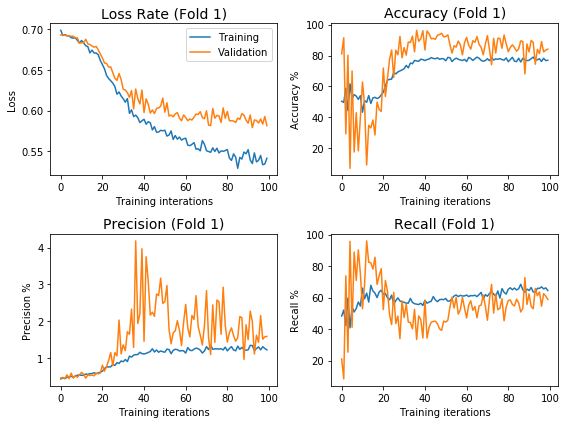

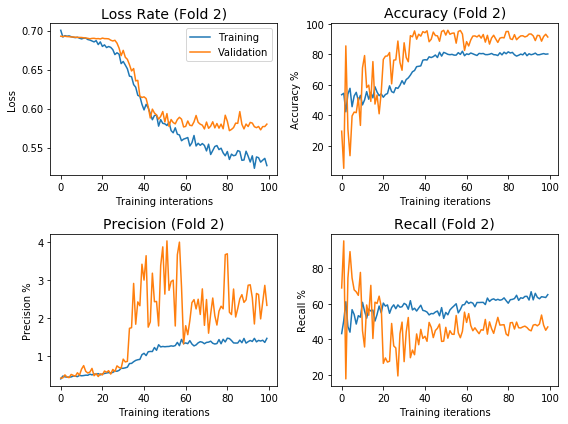

In [148]:
for i in range(2):
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(8,6))

    loss_rate_plot(fithists[i], ax1, legend=True, label="Fold %d"%(i+1))
    accuracy_rate_plot(fithists[i], ax2, label="Fold %d"%(i+1))
    precision_rate_plot(fithists[i], ax3, label="Fold %d"%(i+1))
    recall_rate_plot(fithists[i], ax4, label="Fold %d"%(i+1))

    fig.tight_layout()
    
plt.show()

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else ','
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

---------------
Fold 1:
Confusion matrix, without normalization
[[86917 16227]
 [  178   260]]
---------------
Fold 2:
Confusion matrix, without normalization
[[94359  8785]
 [  229   209]]
---------------
Fold 3:
Confusion matrix, without normalization
[[94641  8503]
 [  234   204]]


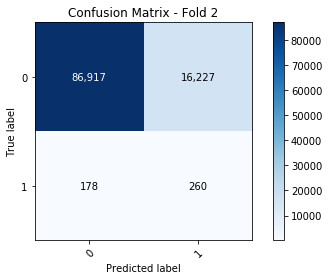

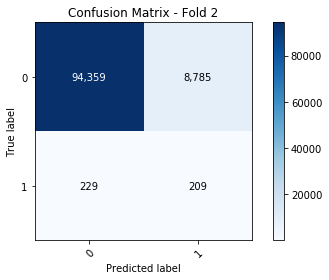

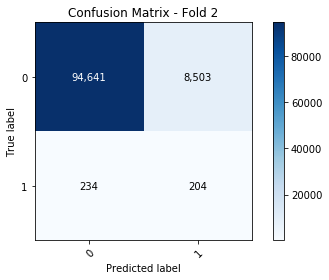

In [150]:
for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("---------------")
    print("Fold %d:"%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    w_train, w_test = np.squeeze(w[train_ix]), np.squeeze(w[test_ix])
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    model = models[ifold]
    
    if include_chromatin_data:
        y_test_pred = model.predict([X_test,chrom_test])
    else:
        y_test_pred = model.predict(X_test)
        
    y_test_pred = np.round(y_test_pred)

    ax = plot_confusion_matrix(y_test, y_test_pred, ['0','1'], title="Confusion Matrix - Fold %d"%(i+1))


In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [0]:
def plot_roc_curve(y_true, y_pred, weights):
    fpr, tpr, _ = roc_curve(y_true, y_pred)#, 
                            #sample_weight = weights)
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_true, y_pred))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0,1],[0,1],'k--')
    ax.set_title("ROC Curve")
    plt.legend(loc='lower right')
    plt.show()
    
    fig.tight_layout()
    return ax

Working on fold 1...
Working on fold 2...
Working on fold 3...


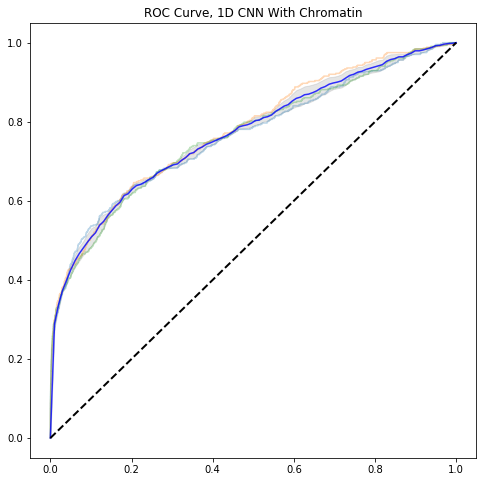

In [153]:
from scipy import interp

fig, ax = plt.subplots(1,1,figsize=(8,8))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("Working on fold %d..."%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    w_train, w_test = np.squeeze(w[train_ix]), np.squeeze(w[test_ix])
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    model = models[ifold]
    
    if include_chromatin_data:
        y_test_pred = model.predict([X_test,chrom_test]).ravel()
    else:
        y_test_pred = model.predict(X_test).ravel()
        
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    ax.plot(fpr,tpr, alpha=0.3)


mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

ax.plot([0,1],[0,1],'--k',lw=2)

ax.set_title('ROC Curve, 1D CNN With Chromatin')

plt.show()